# CNN Visualization

## Team 🧑‍🔬🧑‍🔬🧑‍🔬🧑‍🔬

- Trevor Dohm
- Reece Iriye
- Leland Winston
- Kassi Bertrand

# Explanation as to why we chose VGG_16: #

**Interpretability:** VGG-16's architecture is comprised of relatively simple convolutional blocks followed by max-pooling layers and fully connected layers. We can have a better of idea of the transformations that are taking place in network because of its simple architecture.  The absence of residual connections removes the complexity associated with shortcut connections in other architectures, allowing for a more straightforward tracing of data transformations and gradient flow. This enhances our ability to dissect and comprehend the network's decision-making process at every layer, an advantage when analyzing the specific features that activate network responses.


**Size:** Its smaller size, compared to more elaborate models, allows for expedited experimentation and testing, without sacrificing the depth of feature detection necessary for our image analysis tasks. This meant it would be easy for us to run our machines and do inference on the model. 

By focusing on these aspects, the explanation emphasizes the balance between the accessibility of VGG-16 and its capacity to serve as a powerful tool for image analysis within the constraints of available computational resources.

In [85]:
import os
import sys
import torch
import numpy as np
import torch.nn as nn
import PIL
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.models import vgg16, VGG16_Weights
from torchsummary import summary

# NOTE: TorchVision offers pre-trained weights for every provided architecture, using the PyTorch torch.hub. 
# Instancing a pre-trained model will download its weights to a cache directory. 
# This directory can be set using the TORCH_HOME environment variable
os.environ['TORCH_HOME'] = './TORCH_HOME'
device = torch.device(
    "cuda" 
    if torch.cuda.is_available() 
#     else "mps" 
#     if torch.backends.mps.is_available() 
    else "cpu"
)

In [2]:
device

device(type='cpu')

`VGG-16` has 13 convolutional layers and 3 fully connected layers. Feeding an arbitrary image of size $(3 \times 256 \times 256)$ and we get the following summary alongside the output shapes and corresponding paramater count:

In [3]:
# VGG-16 using pretrained weights
vgg = vgg16(weights=VGG16_Weights.DEFAULT).to(device)

# Freeze VGG
vgg.eval()

summary(vgg, (3, 256, 256))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

Here is also the classic Pytorch Summary as it contains more information about the dimensions of the filters:

In [5]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Selecting a Multi-Channel Filter



Our team was interested in the multi-channel filter in `Conv 3-3`, the 7th convolution layer counting from the left.

![VGG-16 Archicture diagram](imgs/img-0.png)

`Conv 3-3` corresponds to `Conv2d-15`, the 15th layer in our architecture summary:

```txt
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
           Conv2d-15          [-1, 256, 64, 64]         590,080
================================================================
```

Assuming the batch size being $1$, this layer accepts an input with shape: $(1 \times 256 \times 64 \times 64)$, convolves it with *256 filters*, and produces another tensor of shape $(1 \times 256 \times 64 \times 64)$. Let's start start look at the activations of this layer, when an image passes through it.

### Exploring Activation Patterns in a Specific Convolutional Layer.

Let's display the activations (i.e. the 256 filters) of this `Conv2d-15` when we feed in the following image in the network:

![Test Input image](imagenet-samples/test.JPEG)

To make our life easy, the team used the following snippet to captures the activations in `vgg.features` as an input image travels throughout those layers.

In [4]:
activations_store = {}

def hook_fn(layer_index):
    def hook(module, input, output):
        activations_store[layer_index] = output.detach()
    return hook

# Register hooks for all layers in vgg.features
for layer_index, layer in enumerate(vgg.features):
    layer.register_forward_hook(hook_fn(layer_index))

In [5]:
import torchvision.transforms as transforms
from PIL import Image

# Define the transformation for the input image
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),  # Crop the center of the image to make it square (256x256)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image = Image.open('imagenet-samples/test.JPEG')

# Preprocess the image
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension
input_batch = input_batch.to(device)

# Perform inference
with torch.no_grad():
    output = vgg(input_batch) # (1, 1000)

# Get the index corresponding to the maximum score
_, predicted_idx = torch.max(output, 1)

print("Index of the prediction:", predicted_idx.item())

Index of the prediction: 998


`VGG-16` predicted that the test image belongs to the $998^{th}$ class. Which is correct! Index `998` corresponds to the class: `ear, spike, capitulum`.

Now that we know the model made the correct prediction, let's print out the activations of convolutional layer: `Conv2d-15` just to see what they picked on. Those activations are stored in the `activations` dictionary we created earlier.

In [6]:
activations_store[14].shape

torch.Size([1, 256, 64, 64])

The team wrote the following helper to make displaying the activations of convolutional layers in the network easier

In [7]:
def display_activations(activations: torch.Tensor):
    """
    Display activations in a grid using matplotlib.
    
    Args:
    - activations: Activations tensor of shape [1, channels, height, width]
    """
    # Get the dimensions
    batch_size, num_channels, height, width = activations.shape
    
    # Calculate the number of rows and columns for the grid
    num_rows = int(np.ceil(np.sqrt(num_channels)))
    num_cols = int(np.ceil(num_channels / num_rows))
    
    # Create a figure and axis objects
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(40, 40))
    
    # Iterate over each channel and display it in the corresponding subplot
    for i in range(num_rows):
        for j in range(num_cols):
            # Calculate the channel index
            channel_idx = i * num_cols + j
            
            # Check if channel index is within the range of available channels
            if channel_idx < num_channels:
                # Get the activation for the current channel
                activation = activations[0, channel_idx]
                
                # Display the activation
                axes[i, j].imshow(activation, cmap='hot', interpolation='nearest')  # Using 'hot' colormap
                axes[i, j].axis('off')
            else:
                # If there are less channels than subplots, remove the empty subplot
                fig.delaxes(axes[i, j])
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

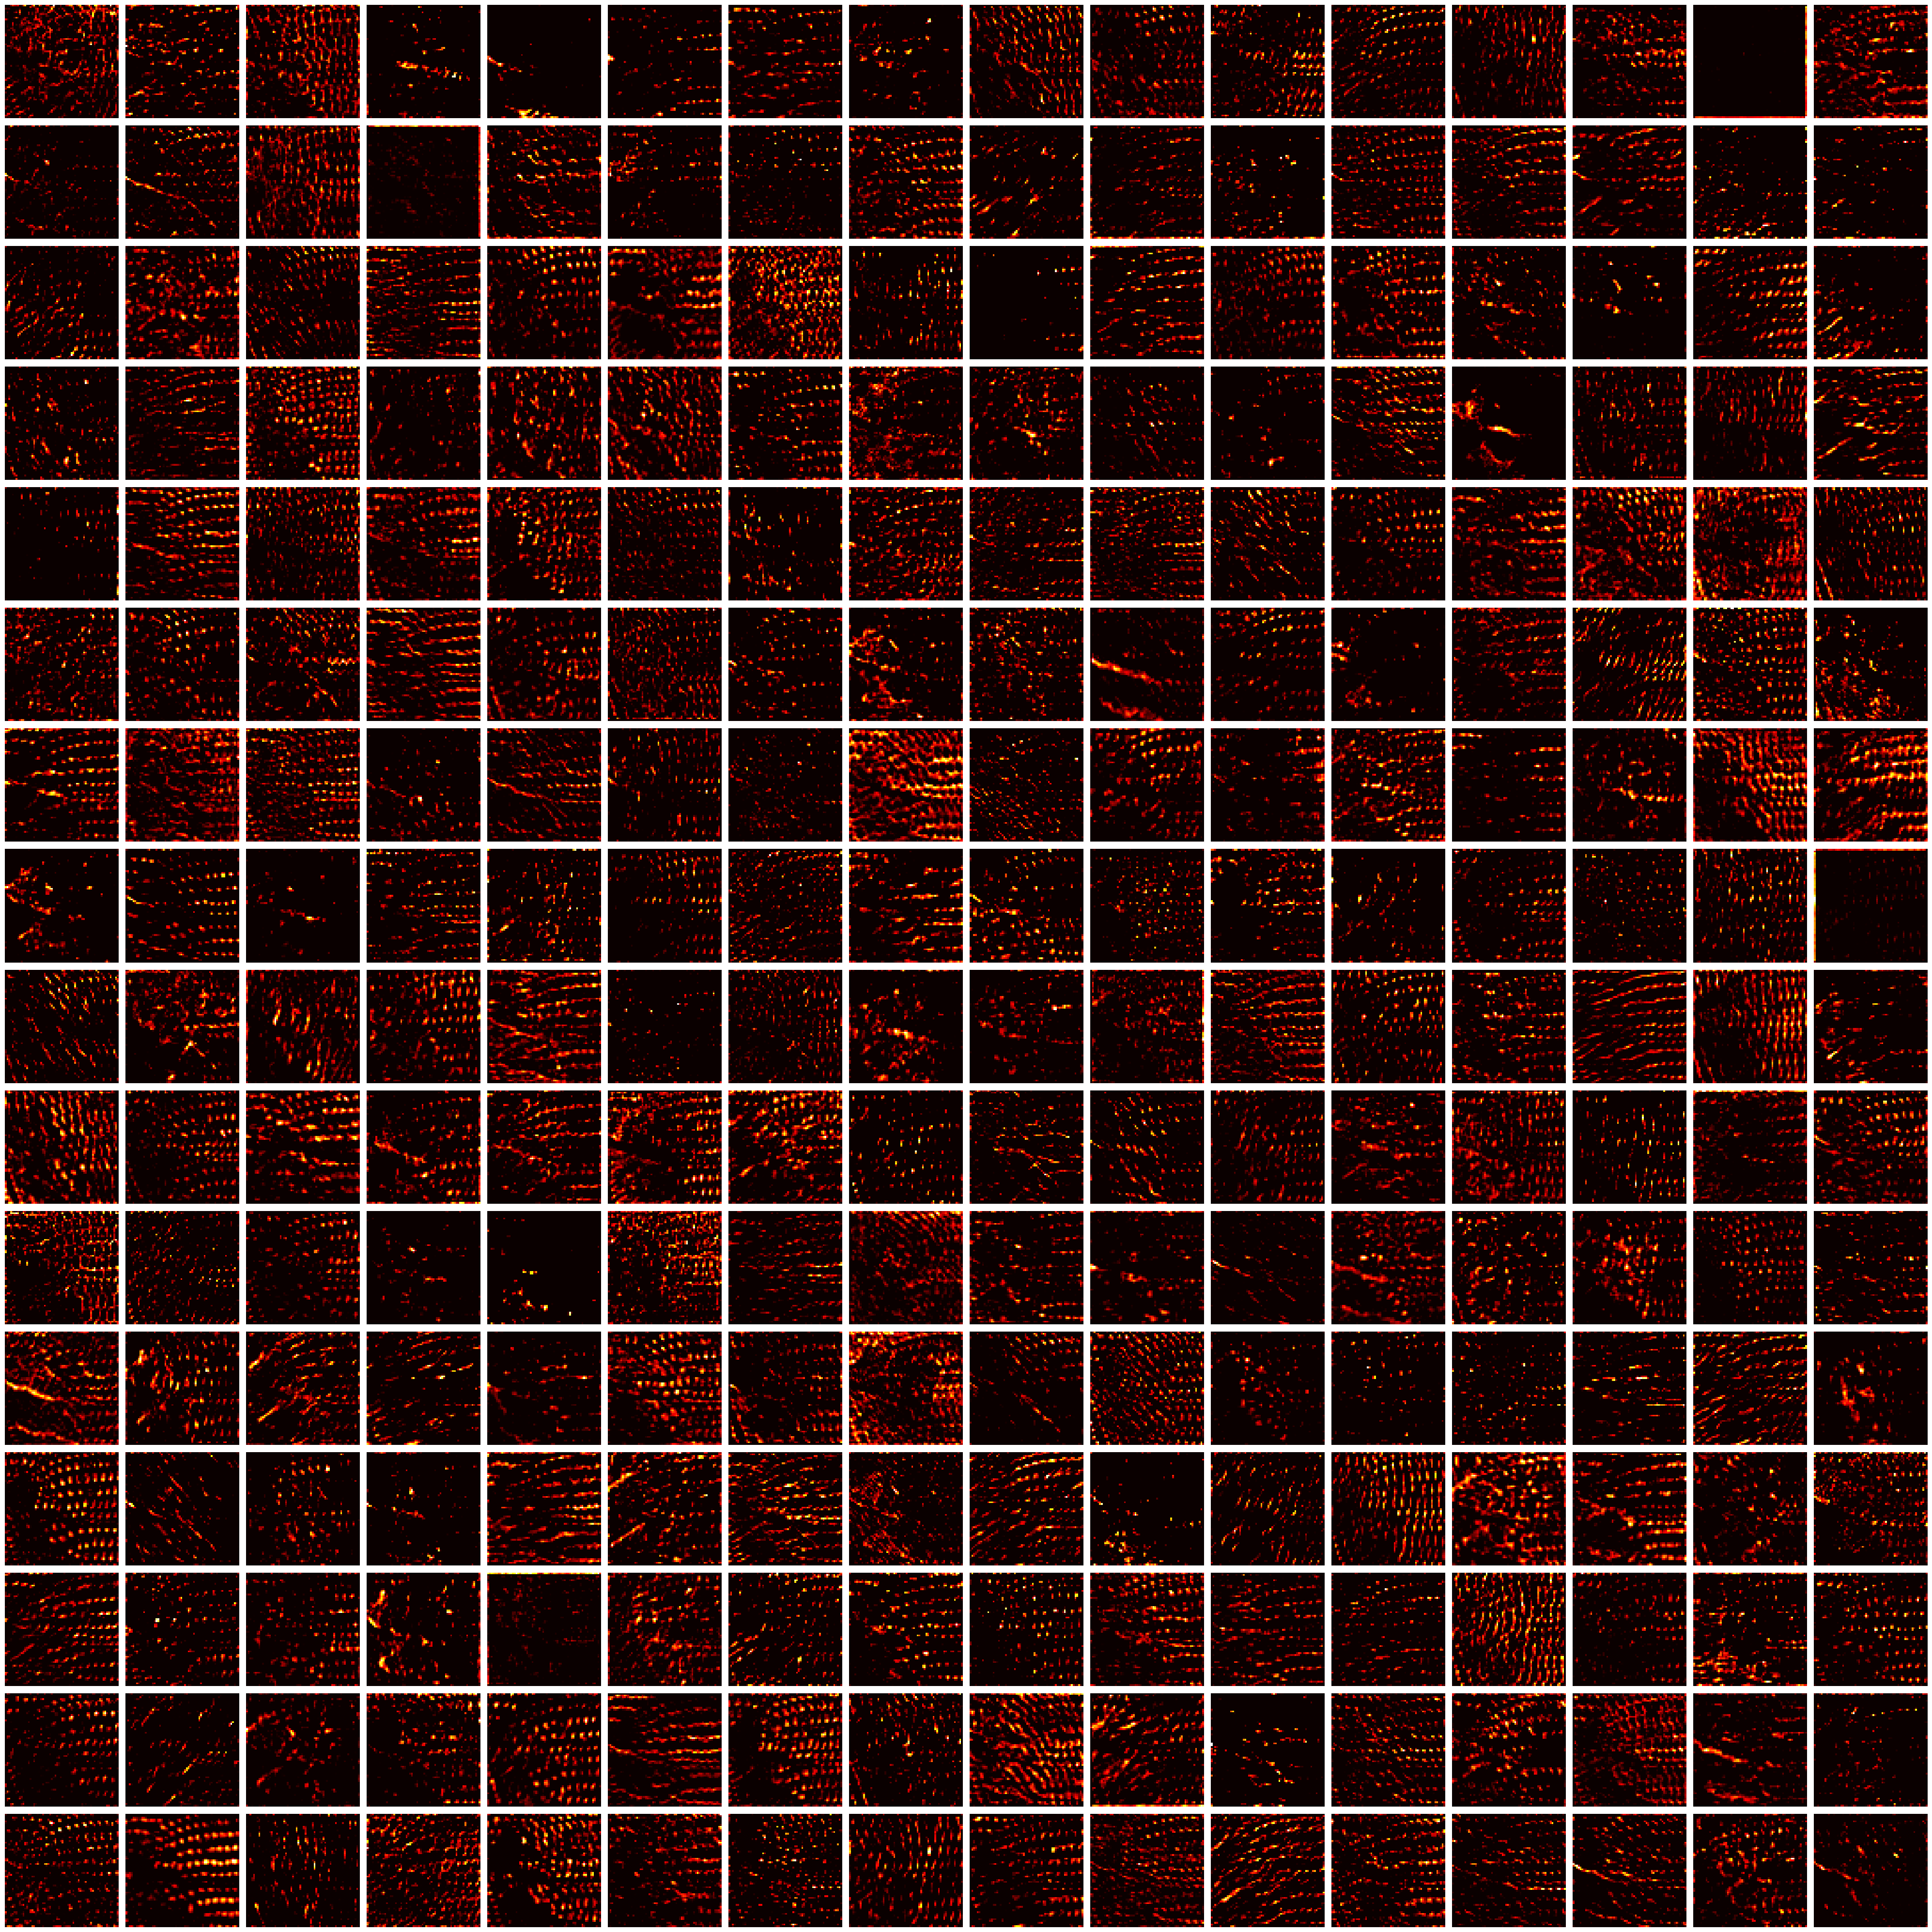

In [8]:
# Display the activations of the 15th layer in the network
display_activations(activations_store[14].cpu())

It looks like the `Conv2d-15` picks up on the yellow grains for the most part, at least judging by the heatmap above.

### Using gradient techniques, find an input image that maximally excites the chosen filter.

To find an input image that maximally excites a given channel in a mutli-channel filter, the team used the following function.

In [81]:
def find_max_excitation_image(target_conv_layer: int, filter_index, optimization_steps: int = 100, show_loss=True):

    # Define a random input image or initialize with random noise
    input_image = torch.randn(1, 3, 256, 256, requires_grad=True, device=device)  # Random noise image

    # Define the optimizer # NOTE: The list of paramaters to optimize is specified. 
    # Only the input image will get updated.
    optimizer = torch.optim.AdamW([input_image], lr=0.07)

    # Optimization loop
    for step in range(optimization_steps):
        # Forward pass. NOTE: This line selects the layers from the beginning of the VGG network (vgg.features) 
        # up to the layer specified by target_conv_layer, then feedforward "input_image". 
        output = vgg.features[:target_conv_layer](input_image)

        # Get the activations of the chosen filter
        activations = output[:, filter_index] # (64, 64)
        
        # By negating the mean activation, My goal was to turn the problem into 
        # an optimization task where the objective is to minimize 
        # the negative of the mean activation. In other words, 
        # to maximize the mean activation
        loss = -torch.mean(activations)
        
        # Zero gradients, perform a backward pass, and update the input image
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print progress
        if show_loss:
            if (step+1) % 10 == 0:
                print(f'Step [{step+1}/{optimization_steps}], Loss: {loss.item()}')

    return input_image

With the previously defined `find_max_excitation_image`, let's find the image that maximally excites the 3rd filter in the chosen multi-channel filter.

In [10]:
target_conv_layer = 14 # "Conv2d-15" layer. The 15th layer in the network
filter_index = 2 # The 3rd filter in the "Conv2d-15", which is Conv3-3

optimized_image = find_max_excitation_image(target_conv_layer, filter_index, 200, show_loss=True)

Step [10/200], Loss: -14.956369400024414
Step [20/200], Loss: -23.495750427246094
Step [30/200], Loss: -30.838184356689453
Step [40/200], Loss: -37.43147277832031
Step [50/200], Loss: -43.517051696777344
Step [60/200], Loss: -49.19957733154297
Step [70/200], Loss: -54.58610534667969
Step [80/200], Loss: -59.756038665771484
Step [90/200], Loss: -64.77316284179688
Step [100/200], Loss: -69.6671142578125
Step [110/200], Loss: -74.46946716308594
Step [120/200], Loss: -79.2140884399414
Step [130/200], Loss: -83.91893005371094
Step [140/200], Loss: -88.59139251708984
Step [150/200], Loss: -93.25225830078125
Step [160/200], Loss: -97.90973663330078
Step [170/200], Loss: -102.56924438476562
Step [180/200], Loss: -107.23629760742188
Step [190/200], Loss: -111.90804290771484
Step [200/200], Loss: -116.59904479980469


Let's save the image in the `imgs` folder, then display it.

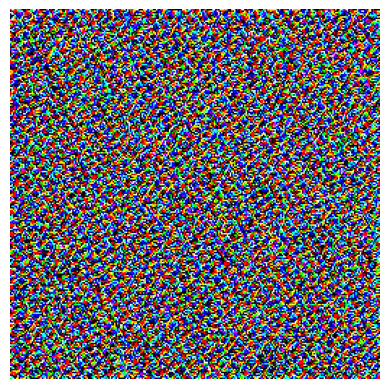

In [11]:
# Convert the optimized image tensor to a numpy array, then make sure px values are within [0, 1]
optimized_image = optimized_image.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)
optimized_image = np.clip(optimized_image, 0, 1)

# Convert numpy array to PIL image, then save it
optimized_image_pil = Image.fromarray((optimized_image * 255).astype(np.uint8))
optimized_image_pil.save("imgs/optimized_image.png")

plt.imshow(optimized_image)
plt.axis('off')
plt.show()

### **Varying Class Images - Check Activations**
- Feed All Images Thru Network, Recording Activations
- Plot Histogram of Activations, Find Most Exciting Class

#### **Section One**

In the first section of the code, we initialize the VGG16 model and load its pre-trained weights. We then create a custom dataset class called ImageNetDataset to load and preprocess the images from the ImageNet dataset. The dataset is then wrapped in a DataLoader to facilitate batch processing.

Next, we define a forward hook function called get_activation that captures the activations of a specific layer in the model. In this example, we attach the hook to the 4th layer of the VGG16 model, which is denoted as 'features.3'. The hook function stores the output of the layer in the activations dictionary.

We then iterate over the first batch of images from the DataLoader and pass them through the model. The forward hook captures the activations of the specified layer for each image in the batch. We print the shape of the captured activations to verify that they have been correctly stored.

For visualization purposes, we select the activations of the first image in the batch (activations_example) and plot them in an 8x8 grid using matplotlib. This allows us to visually inspect the activations extracted from the 4th layer for that particular image.

Finally, we calculate the mean activations across the batch, channel, height, and width dimensions using torch.mean. This gives us a single value representing the average activation for each channel in the 4th layer. We print the mean activations and their shape to examine them further.

Later in the code, we will extend this analysis to the 15th layer of the VGG16 model, following a similar approach to gain insights into the activations at a deeper level of the network.


In [86]:
# Externals
import os
import sys
import ast
import PIL
import torch
import random
import scipy.io
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from collections import defaultdict
from torchsummary import summary
from torchvision.models import vgg16, VGG16_Weights
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torchvision import transforms

In [87]:
# Check Version, GPU Devices
print('Torch Version:', torch.__version__)
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)} (Memory: {torch.cuda.get_device_properties(i).total_memory / 1e9} GB)")
else:
    print("No GPU Available")

Torch Version: 2.2.1
No GPU Available


In [88]:
# Force Torch Home, Set Device
os.environ['TORCH_HOME'] = './TORCH_HOME'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Shove Model Into Device UwU (*Plort*)
model = models.vgg16(pretrained = True).to(device)
model.eval()

/Users/lelandwinston/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/lelandwinston/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Custom Dataset Class
class ImageNetDataset(Dataset):
    def __init__(self, root_dir, transform = None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root_dir) for f in filenames if f.endswith('.JPEG')]
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# Image Transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
])

# Dataset, DataLoader
root_dir = '/users/tdohm/work/Imagenet'
imagenet_dataset = ImageNetDataset(root_dir = root_dir, transform = transform)
data_loader = DataLoader(imagenet_dataset, batch_size = 10, shuffle = True)

# Define Forward Hook To Capture Activations
activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Attach Hook
layer_name = 'features.3'
getattr(model, layer_name.split('.')[0])[int(layer_name.split('.')[1])].register_forward_hook(get_activation(layer_name))

# Processing Images, Capturing Activations
for i, images in enumerate(data_loader):
    images = images.to(device)
    output = model(images)
    
    # Example Of Activations
    current_activation = activations[layer_name]
    print(f"Batch {i + 1}, Activation Shape: {current_activation.shape}")

    # Stop After Iteration
    break

In [ ]:
## OUTPUT: Batch 1, Activation Shape: torch.Size([10, 64, 256, 256])

In [ ]:
# Obtain Activations For Example
activations_example = activations[layer_name][0]

# Plotting 64 Activations
fig, axes = plt.subplots(8, 8, figsize = (20, 20)) 
for i, ax in enumerate(axes.flat):
    if i < 64:
        ax.imshow(activations_example[i].cpu().numpy(), cmap = 'viridis')
        ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Print Mean Activations
mean_activations = torch.mean(activations[layer_name], dim = (0, 2, 3))
print(mean_activations, mean_activations.shape)

In the previous analysis, we observed a correspondence between the activation plot and the mean activations. Among the 64 mean activations computed, only three values were greater than 1. These three highly activated regions in the activation plot align with the visual observations, where two of the regions focus on the fish in the image, and the third region focuses on the background.

The activation plot provides a visual representation of the activations extracted from the 4th layer of the VGG16 model for a single image. The highly activated regions in the plot indicate that the model is detecting and responding strongly to specific features or patterns in those areas of the image. In this case, the model seems to be capturing relevant information about the fish and the background.

The mean activations, on the other hand, provide a quantitative measure of the average activation across the entire batch of images for each channel in the 4th layer. Having only three mean activations greater than 1 suggests that these channels are consistently activated across the batch, indicating their importance in capturing relevant features.

The correspondence between the activation plot and the mean activations highlights the model's ability to focus on salient features and patterns in the input images. The highly activated regions in the plot align with the channels that have high mean activations, demonstrating the model's sensitivity to specific visual features.

Building upon this analysis, we now move on to the second section of the code, where we aim to generalize these findings to the entire ImageNet dataset. By examining a larger set of images, we can gain a more comprehensive understanding of the model's behavior and the features it learns to detect at different layers of the network. This generalization will provide insights into the model's performance and its ability to capture relevant features across a diverse range of images.

#### **Section Two**

In this section, we extend the analysis to the entire ImageNet dataset by iterating over all images and capturing the activations at the 4th and 15th layers of the VGG16 model. We define a dictionary called activations to store the activations and register forward hooks to the specified layers using get_activation function.

We initialize variables to keep track of the mean activations for each class, a counter for the number of images processed per class, and set a limit on the number of images to process per class. We then iterate over the class folders in the ImageNet dataset using a progress bar from the tqdm library to monitor the progress.

For each class folder, we randomly select a subset of images (up to the specified limit) and process them one by one. We load and preprocess each image using the defined transformations, move it to the device, and perform a forward pass through the model. We extract the mean activation for the specified layer (in this case, layer 14) and update the dictionary mean_activations_by_class with the mean activation for the current class. We also update the counter for the current class.

Once we have processed all the classes (or reached the specified class limit), we calculate the average mean activations for each class using the average_activations dictionary. We then sort the classes based on their average activation values in descending order and select the top N classes (in this case, N=10) using sorted_classes_by_activation.

We plot a horizontal bar chart using matplotlib to visualize the top N classes with the highest average activations. The class labels are obtained from the class_labels list, and the corresponding activations are stored in the activations list. The chart displays the class labels on the y-axis and the average activations on the x-axis.

To retrieve the class names corresponding to the class labels, we load a text file (imagenet_2012_clsidx_to_labels.txt) that contains the mapping between class IDs and their corresponding labels. We parse the file and store the mapping in the id_to_label dictionary. We then retrieve the labels for the classes using the class_labels list and print them along with their class IDs.

Additionally, we provide code to display a random image from a specified class index. We specify the path to the ImageNet training data and the desired class index. We retrieve the subdirectory corresponding to the class index, get all the image files in that subdirectory, and randomly select an image. We then open and display the selected image using matplotlib.

Finally, we mention that we have shown some other bar plot visualizations for classes such as the diamondback rattlesnake and others that are used in the analysis but not included in the top 10 most exciting classes. These visualizations can be easily modified to include the class names if needed.

In [ ]:
# Specify Paths (Imagenet)
imagenet_path = '/users/tdohm/work/Imagenet/train'

# Define Transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
])

# Dictionary Storing Activation
activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Register Hook To Model
model.features[0].register_forward_hook(get_activation('features.14'))

# Initialization
mean_activations_by_class = {}
class_counter = defaultdict(int)
limit_per_class = 5
count_limit = 0

# Initialize TQDM Progress Bar
total_classes = len(os.listdir(imagenet_path))
pbar = tqdm(total = total_classes, desc = "Processing Classes")

# Iterate Over Class Folders In ImageNet Dataset
for idx, class_folder in enumerate(sorted(os.listdir(imagenet_path))):
    class_path = os.path.join(imagenet_path, class_folder)
    if not os.path.isdir(class_path):
        continue
    
    # Get Image Files From Class Folder
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    # Randomly Select Some Images From Class Folder
    selected_images = random.sample(image_files, min(limit_per_class, len(image_files)))
    
    # Process Each Selected Image
    for image_file in selected_images:
        image_path = os.path.join(class_path, image_file)
        
        # Load, Preprocess Image
        image = Image.open(image_path).convert('RGB')
        image = transform(image).unsqueeze(0)
        
        # Move Image To Device
        image = image.to(device)
        
        # Forward Pass Through Model
        with torch.no_grad():
            _ = model(image)
        
        # Extract Mean Activation For Specified Layer
        # mean_activation = activations['features.14'].mean(dim = [2, 3]).cpu().numpy().flatten()[0]
        mean_activation = activations['features.14'][:, 2].cpu().mean().item()

        # Update Dictionary With Mean Activation For Current Class
        if class_folder in mean_activations_by_class:
            mean_activations_by_class[idx].append(mean_activation)
        else:
            mean_activations_by_class[idx] = [mean_activation]
    
    # Update Counter For Current Class
    class_counter[idx] += len(selected_images)
    
    # Update TQDM Progress Bar If Class Limit Reached
    if class_counter[idx] >= limit_per_class:
        count_limit += 1
    pbar.update(1)
    if count_limit >= 1000:
        break

# Close Bar
pbar.close()

In [ ]:
# Calculate Average Mean Activations For Each Class
average_activations = {class_id: np.mean(activations) for class_id, activations in mean_activations_by_class.items()}

# Sort Classes By Average Activation
sorted_classes_by_activation = sorted(average_activations.items(), key = lambda x: x[1], reverse = True)

# No. Top Classes
top_n = 10

# Obtain Top Classes By Mean Activation
top_classes = sorted_classes_by_activation[:top_n]

# Plotting
class_labels = [label for label, _ in top_classes]
activations = [activation for _, activation in top_classes]
plt.figure(figsize = (10, 8))
plt.barh(range(top_n), activations, color = 'skyblue')
plt.yticks(range(top_n), class_labels)
plt.gca().invert_yaxis()
plt.xlabel('Average Activation')
plt.title(f'Top {top_n} ImageNet Classes Most Exciting Filter (Layer 14)')
plt.show()

In [ ]:
# Define Path To Text File
txt_file_path = '/users/tdohm/work/Advanced-Deep-Learning-Projects/lab3_cnn_visualization/imagenet_2012_clsidx_to_labels.txt' 

# Load Class ID To Label Mapping
id_to_label = {}
with open(txt_file_path, 'r') as file:
    content = file.read()
    id_to_label = ast.literal_eval(content)

# Retrieve Labels For Classes
classes = [id_to_label.get(class_id) for class_id in class_labels]

# Print Retrieved Labels
for class_id, label in zip(class_labels, classes):
    print(f"Class ID: {class_id}, Label: {label}")

In [ ]:
# Specify Training Data Path
imagenet_train_path = '/users/tdohm/work/Imagenet/train'

# Specify Class Index
class_index_to_retrieve = 741

# Get All Class Subdirectories, Sort
class_directories = sorted([d for d in os.listdir(imagenet_train_path) if os.path.isdir(os.path.join(imagenet_train_path, d))])

# Access Subdirectory For Specified Class Index
if class_index_to_retrieve < len(class_directories):
    class_folder_path = os.path.join(imagenet_train_path, class_directories[class_index_to_retrieve])
    
    # Get All Image Files In Class Folder
    image_files = [f for f in os.listdir(class_folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    # Select Random Example
    if image_files:
        random_image_name = random.choice(image_files)
        random_image_path = os.path.join(class_folder_path, random_image_name)
        
        # Open, Display Random Images
        with Image.open(random_image_path) as img:
            plt.imshow(img)
            plt.title(f'Random Image From Class {class_index_to_retrieve}')
            plt.axis('off')
            plt.show()
            
    else:
        print(f"No Images Found: {class_folder_path}")
else:
    print(f"Class Index {class_index_to_retrieve} Out Of Range")


### **Hypothesis**

Based on the analysis of the multi-channel filter's highest average activations, it appears that this filter might be extracting a combination of object sharpness, colorfulness, and distinct patterns. The classes that exhibit the highest activations include syringes, cardoons (which are bright plants with sharp edges), wild animals (specifically alligators and diamondback rattlesnakes, which typically have unique and distinct patterns on their bodies), and other objects that are often brightly colored and have sharp edges.

This hypothesis suggests that the filter is designed to identify objects with bright colors, sharp edges, and distinct patterns, as these are common features among the highly activated classes. It is reasonable to expect that a certain level of the convolutional neural network would be responsible for extracting these important and somewhat abstract concepts about the objects, as they are crucial for accurate classification.

Furthermore, the multi-channel filter appears to be polysemantic, as it seems to extract multiple features of objects that are essential for classification. However, it is worth noting that these different features could be collectively seen as a form of pattern recognition, as sharpness and colorfulness are both types of patterns that the filter might be attempting to detect.

In conclusion, the primary function of this multi-channel filter within the network is likely to extract key features of objects, such as sharpness, colorfulness, and distinct patterns, which are necessary for accurate classification. By identifying these abstract concepts, the filter contributes to the overall performance of the convolutional neural network in recognizing and categorizing various objects.

!["Bar Graph One"](imgs/example1.png)
!["Bar Graph Two"](imgs/example2.png)
!["Chocolate Syringe UwU Shoot Me With It Hehe ^w^ Rawr XD Murrrrr"](imgs/syringe.png)

##### ***"For Your Immediate Satisfaction" - Kassi Bertrand, 24'*** 

## Analyzing Each Channel of the Multi-Channel Filter

### Extract Filter Coefficients

In [11]:
#Accessing the first convolutional layer of model
conv_layer = vgg.features[14]

# Get the weights (filter coefficients) of the convolutional layer
all_filter_weights = conv_layer.weight.data.cpu().numpy()

In [15]:
all_filter_weights.shape

(256, 256, 3, 3)

In [16]:
filter_weights = all_filter_weights[2,:,:,:]
filter_weights.shape

(256, 3, 3)

### Keep Top Ten Sets of Inputs with "Strongest" Weights

In [19]:
# Calculate the L2 norm for each input channel filter
summed_weights = np.linalg.norm(filter_weights, axis=(1, 2))  # Sum over the intended axes
norms = np.sqrt(summed_weights)  # Take the square root to get the L2 norm

top_ten_indices = np.argsort(norms)[-10:]  # Get indices of the top ten strongest filters
top_ten_filters = filter_weights[top_ten_indices]  

In [20]:
top_ten_filters.shape

(10, 3, 3)

In [21]:
top_ten_indices

array([134, 140, 184, 199, 159, 224, 123, 142, 182, 168])

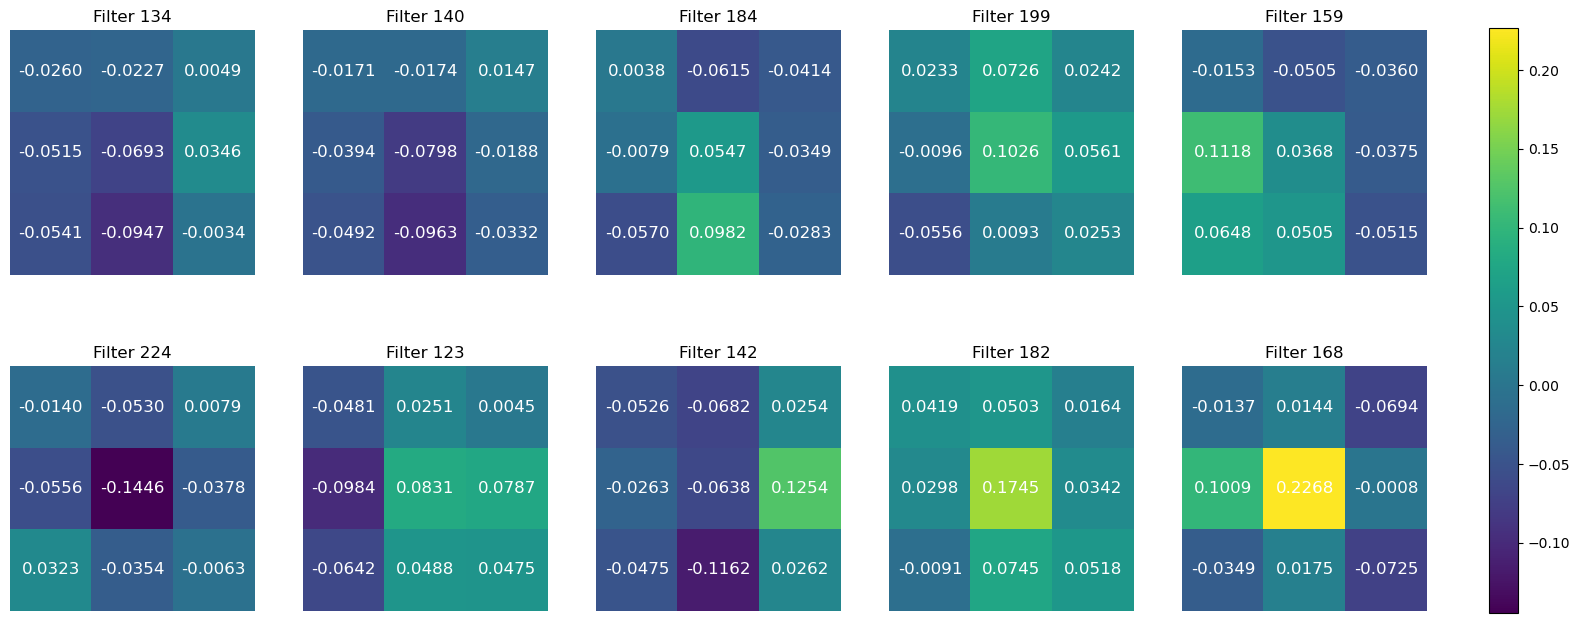

In [79]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

# Calculate the global min and max values across all top ten filters for consistent color scaling
vmin, vmax = top_ten_filters.min(), top_ten_filters.max()

for i, ax in enumerate(axes):
    # Apply the global vmin and vmax to ensure consistent color scaling across all subplots
    im = ax.imshow(top_ten_filters[i, :, :], cmap='viridis', interpolation='nearest', vmin=vmin, vmax=vmax)
    ax.set_title(f'Filter {top_ten_indices[i]}')
    ax.axis('off')  # Hide the axes ticks
    
    # Annotate each cell with the exact number
    for j in range(top_ten_filters.shape[1]):  # For each row
        for k in range(top_ten_filters.shape[2]):  # For each column
            # Use a contrasting color for text to ensure readability; adjust as necessary based on your preference
            text = ax.text(k, j, f'{top_ten_filters[i, j, k]:.4f}',
                           ha="center", va="center", color="white",
                           fontsize=12)

# Place the colorbar with accurate representation of the color scale
# Now, the colorbar directly reflects the global vmin and vmax used for all plots
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.95, aspect=20, fraction=0.046, pad=0.04)

plt.show()

### Categorize Inhibitory or Excitatory and Develop Understanding of How Channels Form a Circuit

In [76]:
# Calculate the mean value for each filter
mean_values_per_filter = np.mean(top_ten_filters, axis=(1, 2))
mean_values_per_filter

array([-0.03136928, -0.03739478, -0.0082466 ,  0.027586  ,  0.00812149,
       -0.03406294,  0.00855914, -0.02196515,  0.05158953,  0.01868508],
      dtype=float32)

We took the average across the outputs of the top ten activations.These averages would indicatate that most of activations are inhibitory but there are 3 filters (filter 182, filter 168, filter 199) that are very excitatory.  

This is really interesting to us, given the activations from Conv3-3 in VGG16 are all the input parameters for the ReLU activation function. This is important to keep in mind, especially for filters that are full of solely negative weights like Filter 224, because while magnitudes matter, if all the outputs from Conv3-2 being fed into Conv3-3 were positive, the result would be suppressed to 0. The magnitudes of these weights and their signs are important for searching for specific patterns, and the negative values appear more often and are larger in magnitude on average.

Diving deeper, let's take a look at each of these top 10 most influential ***single channel*** filters:

- `Filter 134`: There is one weight in the filter that is positive and non-zero. This filter is mostly inhibitory.

- `Filter 140`: There is one weight that is positive weight in this filter. This filter is mostly inhibitory. 

- `Filter 184`: This filter migth be learning something interesting because it has a few weights that are very positive despite having a negative average. This filter is mostly inhibitory. 

- `Filter 199`: This filter is also probably learning an interesting pattern. It has a relatively positive weight right in the center of the filter and the shape and its only 2 negative values are in the bottom left corner. This filter is mostly excitatory.  

- `Filter 159`: Again, this filter has one very (relatively) positve weight. Despite its averge being low this filter is mostly excitatory. 

- `Filter 224`: This filter has only two positive weights and a negative avergae of the weights. It is mostly inhibitory.  

- `Filter 123`: This filter is intersting, all of the negative weights are in the first column of the filter while the rest of the weights are positive. This filter is mostly excitatory.   

- `Filter 142`: This filter is similar to the last one just kind of in reverse. All of the weigth values in the right columns are positive. It might be learning something interesting but the filter is mostly inhibitory. 

- `Filter 182`: This is the filter with the highest average of its weights. It has one very high value in the center and only one negative weight in the bottom left corner. This filter is mostly excitatory. 

- `Filter 168`: This filter is mostly excitatory and has the heighest weight value in all of the filters but still has lower weight average than the than the previous filter. All of the negative weights are in the corners of the filter. 


By isolating the top ten influential filters based on the L2 norm and categorizing them as mostly inhibitory or excitatory, we essentially map out the wiring of our neural circuit. For example, Filter 182, with a high central positive weight, resembles a node that is finely tuned to a specific feature, possibly activating when that feature is centrally located in the receptive field. Filter 224, being mostly inhibitory, functions like a noise suppressor, only allowing signals through when they are strong enough to overcome the negative bias.


Through the process of backpropagation and the repeated application of these filters across many iterations of training, the network optimizes these circuits, sharpening their response to features that are crucial for the task at hand. In doing so, the network creates pathways through backpropogation that lead to the desired output based on the input data it encounters. Understanding these pathways is critical to interpret the network's decision-making and further tailoring it to specialized tasks, such as identifying specific components in visual patterns, which in the context of VGG-16 could translate to improved performance in classification.

## Visualize Image the Filters are Excited By

Generating Excited Image 1
Step [10/400], Loss: -29.65603256225586
Step [20/400], Loss: -53.76753616333008
Step [30/400], Loss: -77.0322494506836
Step [40/400], Loss: -100.63170623779297
Step [50/400], Loss: -124.7415771484375
Step [60/400], Loss: -149.3234405517578
Step [70/400], Loss: -174.27325439453125
Step [80/400], Loss: -199.48472595214844
Step [90/400], Loss: -224.8553924560547
Step [100/400], Loss: -250.3056640625
Step [110/400], Loss: -275.8338317871094
Step [120/400], Loss: -301.4012145996094
Step [130/400], Loss: -326.9670104980469
Step [140/400], Loss: -352.6554260253906
Step [150/400], Loss: -378.34808349609375
Step [160/400], Loss: -404.025146484375
Step [170/400], Loss: -429.66424560546875
Step [180/400], Loss: -455.24005126953125
Step [190/400], Loss: -480.7366638183594
Step [200/400], Loss: -506.1432189941406
Step [210/400], Loss: -531.4700317382812
Step [220/400], Loss: -556.7012329101562
Step [230/400], Loss: -581.8419799804688
Step [240/400], Loss: -606.86358642578

Step [390/400], Loss: -966.341064453125
Step [400/400], Loss: -989.2289428710938
Generating Excited Image 6
Step [10/400], Loss: -26.446441650390625
Step [20/400], Loss: -54.839359283447266
Step [30/400], Loss: -83.10684967041016
Step [40/400], Loss: -112.01717376708984
Step [50/400], Loss: -141.78854370117188
Step [60/400], Loss: -172.21170043945312
Step [70/400], Loss: -203.1857147216797
Step [80/400], Loss: -234.5425262451172
Step [90/400], Loss: -266.11724853515625
Step [100/400], Loss: -297.7348327636719
Step [110/400], Loss: -329.420166015625
Step [120/400], Loss: -361.1160583496094
Step [130/400], Loss: -392.82843017578125
Step [140/400], Loss: -424.4634094238281
Step [150/400], Loss: -455.99859619140625
Step [160/400], Loss: -487.4673767089844
Step [170/400], Loss: -518.9010009765625
Step [180/400], Loss: -550.2325439453125
Step [190/400], Loss: -581.4307861328125
Step [200/400], Loss: -612.412841796875
Step [210/400], Loss: -643.143798828125
Step [220/400], Loss: -673.63500976

Step [370/400], Loss: -581.4049072265625
Step [380/400], Loss: -596.47021484375
Step [390/400], Loss: -611.38232421875
Step [400/400], Loss: -626.1875


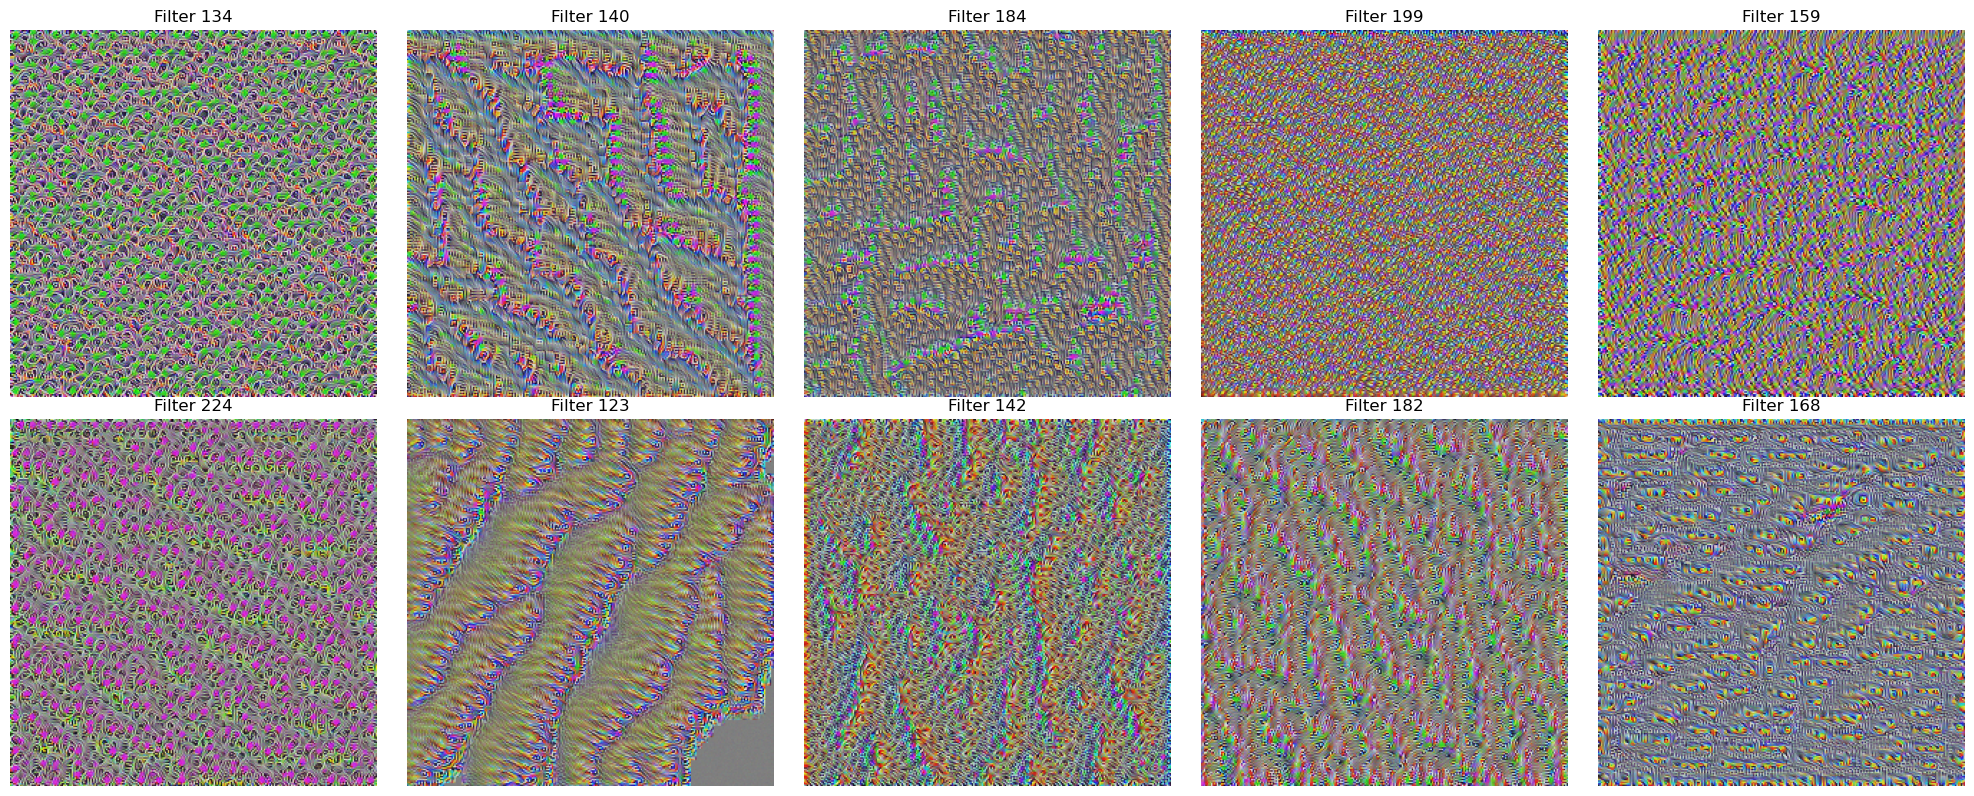

In [83]:
# Function to normalize and convert the image tensor for visualization
def tensor_to_image(tensor):
    
    tensor = tensor.detach().cpu()
   
    tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())
    
    return transforms.ToPILImage()(tensor.squeeze())

# Function to plot maximally excited images
def plot_max_excited_images(top_ten_indices, target_conv_layer, optimization_steps=100):
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))  
    axes = axes.flatten()
    
    image_list = []

    for i, filter_index in enumerate(top_ten_indices):
        # Generate maximally excited image for the current filter
        print(f"Generating Excited Image {i+1}")
        excited_image = find_max_excitation_image(target_conv_layer, filter_index, optimization_steps)

        # Convert tensor to image
        image = tensor_to_image(excited_image)
        image_list.append(image)

        # Plot image
        axes[i].imshow(image)
        axes[i].set_title(f'Filter {filter_index}')
        axes[i].axis('off')  # Hide the axes ticks

    plt.tight_layout()
    plt.show()
    
    return image_list

# Call the plotting function for all filters in top_ten_indices
target_conv_layer = 14
excited_images = plot_max_excited_images(top_ten_indices, target_conv_layer=target_conv_layer, optimization_steps=400)

These are the images that maximally excite each of these super influential inhibitory filters that were mentioning. Diving deep into each of these filters, with description matches highly inspred by <a href=https://distill.pub/2020/circuits/early-vision/>this link</a>:

- `Filter 134`: The image suggests the filters appear to be sensitive to patterns with green dots and purple swirls surrounding these dots. From the given image, it seems that this particular filter in Conv3-3 in VGG-16 is trained to respond strongly to circular or dot-like patterns (the green dots) that are surrounded by curving or swirling lines (the purple or sometimes orange/yellow/red swirls). From the given image, it seems that this particular filter in the network is trained to respond strongly to circular or dot-like patterns (the green dots) that are surrounded by curving or swirling lines (the purple swirls). Since ImageNet contains a broad set of classes, so catching these discrete dots with pronounced surroundings (like corn kernels for example) is important at this point in the middle of the network.
- `Filter 140`: This particular image suggests the image might be useful for detecting objects with a flowing or curved nature in the images the network is analyzing, helping the network to build up a more intricate understanding of shapes and structures—as well as the details inside the curves and lines. The straight lines and curves are primarily pink with a little green on the outside, and outside of these curve and straight line structures is a grid-like/hatch-texture-like background or blurred swirls. We aren’t really seeing any line or curve divergence in this maximally excited image, showcasing how this filter is really hunting for edges with patterns, and the background is somewhat patterned and somewhat blurred. 
- `Filter 184`: This particular image suggests that the image may appear to be sensitive to bright colored lines with decently long linear lines. These lines are pretty closely perpendicular to the x- and y-axes on the image, and they have bright green with a splash of pink on occasion. The background here has a similar pattern as the one that appears in the line, just with a not-very-bright yellow as its primary color instead. This is important, because like the filter before, this filter highlights lines with bright internal patterns with a less emphatic background. It’s a little different than the previous filter though than Filter 140 because it adds versatility to highlight these bright and defined linear patterns regardless of not the background the background also has a pattern or is a little more blurred.
- `Filter 199`: This particular image appears to react to color-rich, vivid photos based on this maximally excited image. We can also tell through this image that maximally excites the filter that the filter reacts to super abrupt changes in one bright color to another bright color. We also see very slight purple lines and curves in this image that maximally excites the filter with overwhelmingly yellow backgrounds with splashes of light and dark blue and a hint of red and green. 
- `Filter 159`: This image is an abstract pattern. The image presents a consistent and repeating pattern filled with vibrant and saturated colors. The image also looks like it contains swirls and curves that  contributes to a kaleidoscopic effect. The array of colors range from deep blues to fiery reds, yellows, and vivid greens. The colors are arranged in such a way that they seem to dance and intertwine across the visual plane. Even with this abstract pattern with a slightly uniform pattern across the image, some lines emphatically perturb out of the filter with a thicker version of the pattern than the parts that visually appear to be a little further away.
- `Filter 224`: This image showcases regular patterns exhibiting prominent pink and green colors. Those colors are arranged in an intertwined manner creating viney-like patterns. It’s similar to the maximally excited image from Filter 134, but the dots are light pink, there is a muted mid-green color in appearance with the viney pattern, and there are bright green curves with dark holes in them. 
- `Filter 123`: This image presents strong evidence of waves on the beach with a dynamic array of curving patterns that resemble the undulating ridges of sand formed by the retreat of sea waves. The visual texture suggests the granularity of sand. The bottom right corner of this image suggests that the image died at some point when stepping through with our optimizer during the gradient ascent algorithm, but because it’s such a small part of the image, the clear pattern is still pretty visibly seen. The blurred (almost fur-like) yellow/red backgrounds travel to the left of the light-blue/purple/pink large curves. This image suggests that this filter may be strong at catching these curves with internal bright-colored patterns. 
- `Filter 142`: The image contains muted yellow swirls as a background with light-blue curves in a swirly pattern with splashes of neon pink. 
- `Filter 182`: Staying on theme with most if the images in these filters this looks like another curve and line detector. It appears that it is mostly picking up a consistent patterns as well as the colors within those patterns. It also appears that there might be a "meta" pattern appearing as it appears to outline some of the patterns within the image. 
- `Filter 168`: Based on this image, this filter seems to be maximally excited by purple, green, and muted color curves. it has similar patterns to some of the fur filters in the link from circuits. The bright light green patterns contain dark curves that look very similar to level curves.

All of these filters suggest that the circuit reacts heavily to bright colors that contrast with its surrounding background. We do believe our multi-channel filter is polysemantic in the patterns that it reacts to but not in the colors it reacts to. Across all 10 images for these 10 most powerful filters, bright colors popping out tend to be a very common theme. However, some of these images that maximally excite our powerful filters have lines and curves with embedded patterns inside of them, and some of them have eyes/dots that pop out. The previous images with the diamond rattlesnake, the syringe, the prayer rug, and the cardoons largely contain complex, sharp patterns with contrasting backgrounds, and that tendency for the excitement of these images can be associated with this. 

From the variety of patterns displayed, it's pretty clear that the filters in the circuit are detecting specific features within their respective receptive fields. For pose invariance, we would want consistency in feature detection despite changes in the orientation of those features. The curvilinear patterns and the dots do appear in a variety of positions across multiple filters, so we can conclusively say the circuit is pretty pose invariant. The syringe was caught at a horizontal orientation, the prayer rug was oriented vertically, and the snake had a multitude of defined scales, and all these things contrasted with their backgrounds.  

Going back to our previous hypothesis, we would say that this evidence confirms it. Bright colors (some of which have inner complex patterns within the curvilinear patterns) are clearly what excite this filter along with color contrasting with the background. Lines and curves (but especially lines) are detected from a multitude of orientations too. 